In [9]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/Uncertainty_Modeling")

from utils import make_flow, ensemble_pred  # must be in your Python path or notebook directory

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [10]:
# Set paths
trial_dir = "/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/Uncertainty_Modeling/Fit_Weights/results_no_norm_fit_weights_NF/N_100000_seeds_60_bootstraps_1_4_16_128_15"
data_path = "/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/Uncertainty_Modeling/Generate_Data/saved_generated_target_data/100k_target_training_set.npy"
out_dir = "/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/Uncertainty_Modeling/Generate_Ensemble_Data_Hit_or_Miss_MC/saved_generated_ensemble_data"
os.makedirs(out_dir, exist_ok=True)

# Reference architecture (consistent across models)
arch_config_path = "/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/Uncertainty_Modeling/Train_Models/EstimationNF_gaussians_outputs/N_100000_seeds_60_bootstraps_1_4_16_128_15/architecture_config.json"

In [11]:
# Load model weights and configs
with open(arch_config_path) as f:
    config = json.load(f)

f_i_statedicts = torch.load(os.path.join(trial_dir, "f_i_averaged.pth"), map_location=device)
#w_i_fitted = torch.tensor(np.load(os.path.join(trial_dir, "w_i_fitted.npy")), dtype=torch.float64)
w_i_fitted = torch.tensor([ 0.0489, -0.0549,  0.0217,  0.0400,  0.0104,  0.0634,  0.0098,  0.0756,
         0.0213,  0.0335,  0.0505, -0.0053,  0.0017,  0.0108,  0.0127,  0.0066,
         0.0315,  0.0264,  0.0262,  0.1018,  0.0717,  0.0223,  0.0015, -0.0130,
         0.0351,  0.0155,  0.0271,  0.0563,  0.0065,  0.0513,  0.0528, -0.0659,
         0.0601, -0.0258, -0.0198, -0.0387,  0.0280, -0.0160,  0.0431, -0.0626,
         0.0246,  0.0034, -0.0270,  0.0072, -0.0303,  0.0098, -0.0195, -0.0674,
         0.0384,  0.0571,  0.0251, -0.0116,  0.0485,  0.0325,  0.0231,  0.0251,
         0.0107, -0.0070,  0.0596,  0.0358], dtype=torch.float64)

# Load data
x_data = torch.from_numpy(np.load(data_path)).float().to(device)
print("Data shape:", x_data.shape)
print("Loaded", len(f_i_statedicts), "models")


Data shape: torch.Size([100000, 2])
Loaded 60 models


In [12]:
f_i_models = []
for state_dict in f_i_statedicts:
    flow = make_flow(
        num_layers=config["num_layers"],
        hidden_features=config["hidden_features"],
        num_bins=config["num_bins"],
        num_blocks=config["num_blocks"],
        tail_bound=config["tail_bound"]
    ).to(device)
    flow.load_state_dict(state_dict)
    flow.eval()
    f_i_models.append(flow)


In [13]:

# Define ensemble callable f(x1, x2) using the fitted weights and flow models
def f(x1, x2, f_i_models, w_i_fitted):
    """
    Compute ensemble density f(x1, x2) = sum_i w_i * f_i(x1, x2)
    Input: x1, x2 of shape (N,) — output: (N,)
    """
    x = torch.stack([x1, x2], dim=1)  # shape (N, 2)
    with torch.no_grad():
        probs = torch.stack([torch.exp(model.log_prob(x)) for model in f_i_models], dim=1)  # (N, M)
        w = w_i_fitted.to(probs.device)
        return (probs * w).sum(dim=1)  # shape (N,)

In [14]:
torch.sum(w_i_fitted)

tensor(1.0002, dtype=torch.float64)

In [18]:

def hit_or_miss_2d(x1_min, x1_max, x2_min, x2_max, f_i_models, w_i_fitted, N_events, max_attempts=1000000000):
    """
    Monte Carlo sampling via hit-or-miss in 2D using PyTorch.

    Args:
        x1_min, x1_max: float, bounds for x-axis
        x2_min, x2_max: float, bounds for y-axis
        f: callable, probability density function f(x1, x2) -> torch.tensor (same shape as x1/x2)
        N_events: int, number of samples to generate
        max_attempts: int, maximum number of sampling attempts (to avoid infinite loop)

    Returns:
        samples: torch.Tensor of shape (N_events, 2), the accepted (x1, x2) points
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Estimate f_max by grid sampling
    '''
    x1_grid = torch.linspace(x1_min, x1_max, 400, device=device)
    x2_grid = torch.linspace(x2_min, x2_max, 400, device=device)
    X1, X2 = torch.meshgrid(x1_grid, x2_grid, indexing='ij')
    '''
    with torch.no_grad():
        #f_vals = f(X1.flatten(), X2.flatten(), f_i_models, w_i_fitted)
        #f_max = f_vals.max().item() * 1.1  # Safety factor
        f_max=2
        print('f_max', f_max)

    accepted = []
    total_attempts = 0
    batch_size = int(0.1 * N_events)  # Oversample in batches for efficiency

    while len(accepted) < N_events and total_attempts < max_attempts:
        # Sample uniformly in 2D space
        x1_samples = torch.empty(batch_size, device=device).uniform_(x1_min, x1_max)
        x2_samples = torch.empty(batch_size, device=device).uniform_(x2_min, x2_max)
        y_samples = torch.empty(batch_size, device=device).uniform_(0, f_max)

        with torch.no_grad():
            f_values = f(x1_samples, x2_samples, f_i_models, w_i_fitted)

        mask = y_samples < f_values
        hits = torch.stack([x1_samples[mask], x2_samples[mask]], dim=1)
        print('hits', hits.shape)
        accepted.append(hits)
        total_attempts += batch_size
        print('len(accepted)', len(accepted))

    if accepted:
        samples = torch.cat(accepted, dim=0)[:N_events]

    else:
        raise RuntimeError("No events accepted; check if your function f is correctly normalized and non-zero.")
    print('sampl size', samples.shape)
    return samples

# Sample new events from the ensemble distribution
#tb = config["tail_bound"]
tb = 2.8

samples = hit_or_miss_2d(-tb, tb, -tb, tb, f_i_models, w_i_fitted, N_events=200000) 
np.save(os.path.join(out_dir, "v2_ensemble_generated_samples_4_16_128_15.npy"), samples.cpu().numpy())
print("Saved generated samples.")

f_max 2
hits torch.Size([334, 2])
len(accepted) 1
hits torch.Size([284, 2])
len(accepted) 2
hits torch.Size([365, 2])
len(accepted) 3
hits torch.Size([311, 2])
len(accepted) 4
hits torch.Size([368, 2])
len(accepted) 5
hits torch.Size([300, 2])
len(accepted) 6
hits torch.Size([311, 2])
len(accepted) 7
hits torch.Size([361, 2])
len(accepted) 8
hits torch.Size([307, 2])
len(accepted) 9
hits torch.Size([344, 2])
len(accepted) 10
hits torch.Size([340, 2])
len(accepted) 11
hits torch.Size([291, 2])
len(accepted) 12
hits torch.Size([287, 2])
len(accepted) 13
hits torch.Size([311, 2])
len(accepted) 14
hits torch.Size([338, 2])
len(accepted) 15
hits torch.Size([328, 2])
len(accepted) 16
hits torch.Size([312, 2])
len(accepted) 17
hits torch.Size([350, 2])
len(accepted) 18
hits torch.Size([327, 2])
len(accepted) 19
hits torch.Size([318, 2])
len(accepted) 20
hits torch.Size([317, 2])
len(accepted) 21
hits torch.Size([345, 2])
len(accepted) 22
hits torch.Size([317, 2])
len(accepted) 23
hits torch.S

/tmp/ipykernel_48038/1326766788.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()


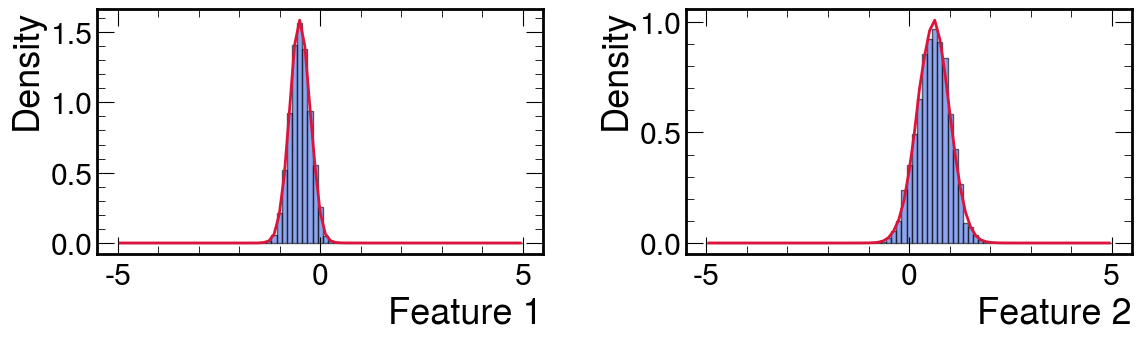

In [12]:
# Compute and plot 1D marginal histograms

# Load samples
generated = samples.numpy()  # shape (N, 2)
x1_samples, x2_samples = generated[:, 0], generated[:, 1]

# Prepare bins
bins = np.linspace(-5, 5, 80)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_width = bins[1] - bins[0]

# Compute ensemble density at bin centers
x1_centers = torch.tensor(bin_centers, dtype=torch.float32, device=device)
x2_centers = torch.tensor(bin_centers, dtype=torch.float32, device=device)

with torch.no_grad():
    # Create 2D grid of (x1, x2) points
    X1, X2 = torch.meshgrid(x1_centers, x2_centers, indexing='ij')  # shape (B, B)
    x1_grid = X1.flatten()
    x2_grid = X2.flatten()

    # Evaluate the function on the 2D grid
    f_vals = f(x1_grid, x2_grid, f_i_models, w_i_fitted).reshape(len(bin_centers), len(bin_centers))

    # Feature 1 marginal: integrate over x2
    f_x1 = f_vals.sum(dim=1).cpu().numpy() * bin_width

    # Feature 2 marginal: integrate over x1
    f_x2 = f_vals.sum(dim=0).cpu().numpy() * bin_width

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, (feature, f_true, label) in enumerate(zip(
    [x1_samples, x2_samples],
    [f_x1, f_x2],
    ["Feature 1", "Feature 2"]
)):
    counts, _, _ = axes[i].hist(
        feature,
        bins=bins,
        density=True,
        alpha=0.6,
        color="royalblue",
        edgecolor="black"
    )
    axes[i].errorbar(
        bin_centers,
        f_true,
        yerr=0,
        fmt='-', color="crimson", lw=2
    )
    axes[i].set_xlabel(label)
    axes[i].set_ylabel("Density")
    axes[i].legend()

plt.tight_layout()
plt.show()



(6283, 2)

In [20]:
np.load("./saved_generated_ensemble_data/ensemble_generated_samples_4_16_128_15_1.npy").shape

(200, 2)